<a href="https://colab.research.google.com/github/sajacaros/optiver/blob/main/sajacaros/04_model_conv1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm


warnings.filterwarnings(action='ignore')
# warnings.filterwarnings(action='default')

In [2]:
running_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
if running_colab:
    data_path = '/content/drive/MyDrive/Colab Notebooks/ai6th/data/optiver/'
else:
    data_path = '../data/'

In [3]:
train_df = pd.read_csv(data_path+'train.csv')
test_df = pd.read_csv(data_path+'test.csv')
submission_df = pd.read_csv(data_path+'sample_submission.csv')
target_df = pd.read_csv(data_path+'revealed_targets.csv')

In [4]:
# null 값 처리
train_df['far_price'] = train_df['far_price'].fillna(0)
train_df['near_price'] = train_df['near_price'].fillna(1)
train_df.isnull().sum()

stock_id                     0
date_id                      0
seconds_in_bucket            0
imbalance_size             220
imbalance_buy_sell_flag      0
reference_price            220
matched_size               220
far_price                    0
near_price                   0
bid_price                  220
bid_size                     0
ask_price                  220
ask_size                     0
wap                        220
target                      88
time_id                      0
row_id                       0
dtype: int64

In [5]:
cols_group_by = ['date_id', 'seconds_in_bucket']
cols_fill_nan = [
    'imbalance_size', 'reference_price', 'matched_size', 'wap',
    'bid_price', 'bid_size', 'ask_price', 'ask_size',
    'stock_id', 'seconds_in_bucket', 'imbalance_buy_sell_flag']
train_grouped_median = train_df.groupby(cols_group_by)[cols_fill_nan].transform('median')
train_df[cols_fill_nan] = train_df[cols_fill_nan].fillna(train_grouped_median)
train_df.loc[train_df.isnull().any(axis=1)] # target 88

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,1381981.10,0,0.999950,9723622.86,0.0,1.0,0.999688,0.0,1.000242,0.0,1.000000,NaN,1925,35_0_131
369700,131,35,10,1371886.54,0,1.000252,9961197.49,0.0,1.0,0.999969,0.0,1.000485,0.0,1.000223,NaN,1926,35_10_131
369892,131,35,20,1331838.54,0,1.000122,9999133.11,0.0,1.0,0.999883,0.0,1.000328,0.0,1.000149,NaN,1927,35_20_131
370084,131,35,30,1350584.58,0,0.999910,10133596.07,0.0,1.0,0.999757,0.0,1.000186,0.0,0.999971,NaN,1928,35_30_131
370276,131,35,40,1327284.70,0,0.999926,10133596.07,0.0,1.0,0.999758,0.0,1.000203,0.0,0.999984,NaN,1929,35_40_131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4225338,158,388,510,339056.84,0,1.001074,19640140.62,0.0,1.0,1.000867,0.0,1.001250,0.0,1.001027,NaN,21391,388_510_158
4225538,158,388,520,437746.70,0,1.001183,19767348.90,0.0,1.0,1.001007,0.0,1.001290,0.0,1.001163,NaN,21392,388_520_158
4225738,158,388,530,483535.46,0,1.000994,19800447.29,0.0,1.0,1.000905,0.0,1.001187,0.0,1.001032,NaN,21393,388_530_158
4225938,158,388,540,453894.62,0,1.000989,20020720.89,0.0,1.0,1.000824,0.0,1.001024,0.0,1.000911,NaN,21394,388_540_158


In [6]:
# (stock_id=131, date_id=35), (stock_id=158, date_id=388) target이 없으므로 제거
train_df = train_df.drop(index=train_df.loc[((train_df['stock_id']==131) & (train_df['date_id']==35))  | ((train_df['stock_id']==158) & (train_df['date_id']==388))].index)
train_df[train_df.isnull().any(axis=1)]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
3555081,101,328,0,3683316.08,0,0.999681,7405651.01,0.0,1.0,0.999647,0.0,1.000356,0.0,1.0,NaN,18040,328_0_101
4764999,19,438,0,2201071.62,-1,1.000146,6841177.82,0.0,1.0,0.999749,0.0,1.000277,0.0,1.0,NaN,24090,438_0_19


In [7]:
# stock_id=101, date_id=328, seconds_in_bucket=0의 target값을 stock_id=101, date_id=328, seconds_in_bucket=1의 target값으로 세팅
train_df.loc[train_df['row_id']=='328_0_101', 'target'] = train_df.loc[(train_df['stock_id']==101) & (train_df['time_id']==18041), 'target'].values
# stock_id=19, date_id=438, seconds_in_bucket=0의 target값을 stock_id=19, date_id=438, seconds_in_bucket=1의 target값으로 세팅
train_df.loc[train_df['row_id']=='438_0_19', 'target'] = train_df.loc[(train_df['stock_id']==19) & (train_df['time_id']==24091), 'target'].values
train_df.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [8]:
scaler = StandardScaler()
selected_features = [
    'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price',
    'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size','wap'
]

train_df.loc[:, selected_features] = scaler.fit_transform(train_df.loc[:, selected_features])
train_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,-1.70084,-0.123545,1.142938,-0.072471,-0.226826,-0.646268,0.018827,0.034295,0.079312,-0.095014,-0.348522,0.003225,-3.029704,0,0_0_0
1,1,0,-1.70084,-0.270456,-1.116064,-0.039302,-0.310765,-0.646268,0.018827,0.067904,-0.436010,0.157572,-0.254889,0.003225,-5.519986,0,0_0_1
2,2,0,-1.70084,-0.263814,-1.116064,-0.171583,-0.309498,-0.646268,0.018827,-0.129348,-0.124376,0.013351,-0.267336,0.003225,-8.389950,0,0_0_2
3,3,0,-1.70084,0.302328,-1.116064,0.069287,-0.191003,-0.646268,0.018827,0.109115,-0.444161,-0.020115,3.289015,0.003225,-4.010200,0,0_0_3
4,4,0,-1.70084,-0.256762,-1.116064,-0.183034,-0.194787,-0.646268,0.018827,-0.132949,-0.317071,-0.098998,-0.410822,0.003225,-7.349849,0,0_0_4


In [9]:
from tqdm.auto import tqdm

X_all = None
y_all = None

for stock_id in tqdm(train_df['stock_id'].unique()):
    stock_data = train_df.loc[train_df['stock_id']==stock_id, selected_features].values
    y_data = train_df.loc[train_df['stock_id']==stock_id, 'target'].to_numpy()
    stock_data = stock_data.reshape(-1, 55, len(selected_features)).transpose(0,2,1)
    y_data = y_data.reshape(-1,55,1).transpose(0,2,1).squeeze() # (95234, 1, 55) =squeeze=> (95234, 55)
    if X_all is None:
        X_all = stock_data
        y_all = y_data
    else:
        X_all = np.concatenate((X_all, stock_data), axis=0)
        y_all = np.concatenate((y_all, y_data), axis=0)
X_all.shape, y_all.shape

  0%|          | 0/200 [00:00<?, ?it/s]

((95234, 12, 55), (95234, 55))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
valid_dataset = TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).float())

In [13]:
batch_size=32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [14]:
import torch.nn as nn

class Conv1dModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            # (N, Cin, Lin) => (N, Cout, Lout)
            # (N, 12, 55) => (N, 32, 52)
            nn.Conv1d(
                in_channels=12,
                out_channels=32,
                kernel_size=4,
                stride=1, padding=0, dilation=1,
                groups=1, bias=True, padding_mode='zeros'
            ),
            nn.LeakyReLU(),
            # (N, 32, 52) => (N, 32, 26)
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.1),
        )

        self.layer2 = nn.Sequential(
            # (N, 32, 26) => (N, 64, 24)
            nn.Conv1d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1, padding=0, dilation=1,
                groups=1, bias=True, padding_mode='zeros'
            ),
            nn.LeakyReLU(),
            # (N, 64, 24) => (N, 64, 12)
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2),
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 12, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 55)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, start_dim=1, end_dim=-1) # (batch_size, 64, 12) -> (batch_size, 64*12)
        x = self.fc(x)
        return x

In [15]:
model = Conv1dModel().to(device)
model

Conv1dModel(
  (layer1): Sequential(
    (0): Conv1d(12, 32, kernel_size=(4,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=55, bias=True)
  )
)

In [16]:
# x, y = next(iter(train_loader))
# x.shape, type(x)

In [17]:
# model(x)

In [18]:
# show params
for p in model.parameters():
    print(p.shape)

torch.Size([32, 12, 4])
torch.Size([32])
torch.Size([64, 32, 3])
torch.Size([64])
torch.Size([512, 768])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([55, 256])
torch.Size([55])


In [19]:
import torch.optim as optim
learning_rate=0.00005
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
criterion = nn.L1Loss()

In [20]:
# Scheduler
from torch.optim import lr_scheduler

lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optimizer,
    T_0=20,
    T_mult=1,
    eta_min=1e-6
)
lr_scheduler

In [21]:
epochs = 100
seq_length = 55

train_epoch_loss = []
valid_epoch_loss = []
for epoch in range(epochs):

    train_iter_loss = []
    bar = tqdm(enumerate(train_loader), total = len(train_loader), desc='Train Loop')
    model.train()
    for idx, (stocks, movements) in bar:
        # with torch.autocast(device_type='cuda', dtype=torch.float64):
        stocks = stocks.to(device)
        movements = movements.to(device)
        outputs = model(stocks)
        loss = criterion(outputs, movements)
        if epoch==0 and idx==0:
            print(movements.shape, outputs.shape)
        train_iter_loss.append(loss.item())
        optimizer.zero_grad() # 기울기 초기화
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()
        bar.set_postfix(
            Epoch = epoch,
            Current_loss = loss.item()/seq_length,
            Train_loss = sum(train_iter_loss)/(idx+1),
            LR = optimizer.param_groups[0]['lr'],
        )
    print(f'Epoch [{epoch+1}/{epochs}] - Train loss : {sum(train_iter_loss)/len(train_loader):.4f}')
    train_epoch_loss.append(sum(train_iter_loss)/len(train_loader))

    model.eval()
    valid_iter_loss = []
    for stocks, movements in enumerate(valid_loader):
        # with torch.autocast(device_type='cuda', dtype=torch.float16):
        with torch.no_grad():
            stocks = stocks.to(device)
            movements = movements.to(device)
            outputs = model(stocks)
            loss = criterion(outputs, movements)
            if epoch==0 and idx==0:
                print(movements.shape, outputs.shape)
            valid_iter_loss.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}] - Valid loss : {sum(valid_iter_loss)/len(valid_loader):.4f}')
    valid_epoch_loss.append(sum(valid_iter_loss)/len(valid_loader))
    gc.collect()

Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

torch.Size([32, 55]) torch.Size([32, 55])
Epoch [1/100] - Train loss : 5.8828


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

torch.Size([32, 55]) torch.Size([32, 55])
Epoch [1/100] - Valid loss : 5.6082


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [2/100] - Train loss : 5.4921


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [2/100] - Valid loss : 5.3320


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [3/100] - Train loss : 5.3245


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [3/100] - Valid loss : 5.1533


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [4/100] - Train loss : 5.1837


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [4/100] - Valid loss : 5.0014


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [5/100] - Train loss : 5.0661


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [5/100] - Valid loss : 4.9181


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [6/100] - Train loss : 4.9762


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [6/100] - Valid loss : 4.8442


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [7/100] - Train loss : 4.9068


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [7/100] - Valid loss : 4.7944


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [8/100] - Train loss : 4.8480


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [8/100] - Valid loss : 4.7545


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [9/100] - Train loss : 4.7988


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [9/100] - Valid loss : 4.7141


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [10/100] - Train loss : 4.7559


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [10/100] - Valid loss : 4.6708


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [11/100] - Train loss : 4.7200


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [11/100] - Valid loss : 4.6495


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [12/100] - Train loss : 4.6917


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [12/100] - Valid loss : 4.6220


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [13/100] - Train loss : 4.6652


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [13/100] - Valid loss : 4.5958


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [14/100] - Train loss : 4.6449


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [14/100] - Valid loss : 4.5796


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [15/100] - Train loss : 4.6258


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [15/100] - Valid loss : 4.5617


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [16/100] - Train loss : 4.6127


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [16/100] - Valid loss : 4.5496


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [17/100] - Train loss : 4.5969


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [17/100] - Valid loss : 4.5360


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [18/100] - Train loss : 4.5838


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [18/100] - Valid loss : 4.5230


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [19/100] - Train loss : 4.5722


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [19/100] - Valid loss : 4.5060


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [20/100] - Train loss : 4.5613


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [20/100] - Valid loss : 4.5069


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [21/100] - Train loss : 4.5513


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [21/100] - Valid loss : 4.4936


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [22/100] - Train loss : 4.5418


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [22/100] - Valid loss : 4.4868


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [23/100] - Train loss : 4.5320


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [23/100] - Valid loss : 4.4738


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [24/100] - Train loss : 4.5223


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [24/100] - Valid loss : 4.4692


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [25/100] - Train loss : 4.5156


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [25/100] - Valid loss : 4.4600


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [26/100] - Train loss : 4.5059


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [26/100] - Valid loss : 4.4540


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [27/100] - Train loss : 4.4974


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [27/100] - Valid loss : 4.4439


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [28/100] - Train loss : 4.4909


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [28/100] - Valid loss : 4.4423


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [29/100] - Train loss : 4.4835


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [29/100] - Valid loss : 4.4488


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [30/100] - Train loss : 4.4755


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [30/100] - Valid loss : 4.4285


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [31/100] - Train loss : 4.4708


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [31/100] - Valid loss : 4.4224


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [32/100] - Train loss : 4.4620


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [32/100] - Valid loss : 4.4123


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [33/100] - Train loss : 4.4567


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [33/100] - Valid loss : 4.4055


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [34/100] - Train loss : 4.4493


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [34/100] - Valid loss : 4.4076


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [35/100] - Train loss : 4.4438


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [35/100] - Valid loss : 4.3938


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [36/100] - Train loss : 4.4357


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [36/100] - Valid loss : 4.3928


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [37/100] - Train loss : 4.4306


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [37/100] - Valid loss : 4.3793


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [38/100] - Train loss : 4.4244


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [38/100] - Valid loss : 4.3765


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [39/100] - Train loss : 4.4197


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [39/100] - Valid loss : 4.3744


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [40/100] - Train loss : 4.4117


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [40/100] - Valid loss : 4.3729


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [41/100] - Train loss : 4.4081


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [41/100] - Valid loss : 4.3610


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [42/100] - Train loss : 4.4001


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [42/100] - Valid loss : 4.3564


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [43/100] - Train loss : 4.3957


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [43/100] - Valid loss : 4.3546


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [44/100] - Train loss : 4.3909


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [44/100] - Valid loss : 4.3464


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [45/100] - Train loss : 4.3844


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [45/100] - Valid loss : 4.3515


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [46/100] - Train loss : 4.3773


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [46/100] - Valid loss : 4.3327


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [47/100] - Train loss : 4.3744


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [47/100] - Valid loss : 4.3314


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [48/100] - Train loss : 4.3676


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [48/100] - Valid loss : 4.3231


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [49/100] - Train loss : 4.3627


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [49/100] - Valid loss : 4.3176


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [50/100] - Train loss : 4.3576


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [50/100] - Valid loss : 4.3151


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [51/100] - Train loss : 4.3527


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [51/100] - Valid loss : 4.3106


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [52/100] - Train loss : 4.3464


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [52/100] - Valid loss : 4.3039


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [53/100] - Train loss : 4.3407


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [53/100] - Valid loss : 4.3034


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [54/100] - Train loss : 4.3361


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [54/100] - Valid loss : 4.2962


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [55/100] - Train loss : 4.3297


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [55/100] - Valid loss : 4.2938


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [56/100] - Train loss : 4.3269


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [56/100] - Valid loss : 4.2881


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [57/100] - Train loss : 4.3207


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [57/100] - Valid loss : 4.2812


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [58/100] - Train loss : 4.3165


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [58/100] - Valid loss : 4.2796


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [59/100] - Train loss : 4.3117


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [59/100] - Valid loss : 4.2727


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [60/100] - Train loss : 4.3059


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [60/100] - Valid loss : 4.2674


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [61/100] - Train loss : 4.2988


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [61/100] - Valid loss : 4.2624


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [62/100] - Train loss : 4.2961


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [62/100] - Valid loss : 4.2593


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [63/100] - Train loss : 4.2906


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [63/100] - Valid loss : 4.2516


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [64/100] - Train loss : 4.2839


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [64/100] - Valid loss : 4.2511


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [65/100] - Train loss : 4.2807


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [65/100] - Valid loss : 4.2467


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [66/100] - Train loss : 4.2759


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [66/100] - Valid loss : 4.2434


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [67/100] - Train loss : 4.2709


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [67/100] - Valid loss : 4.2344


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [68/100] - Train loss : 4.2661


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [68/100] - Valid loss : 4.2375


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [69/100] - Train loss : 4.2602


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [69/100] - Valid loss : 4.2313


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [70/100] - Train loss : 4.2564


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [70/100] - Valid loss : 4.2245


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [71/100] - Train loss : 4.2523


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [71/100] - Valid loss : 4.2162


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [72/100] - Train loss : 4.2473


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [72/100] - Valid loss : 4.2181


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [73/100] - Train loss : 4.2401


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [73/100] - Valid loss : 4.2149


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [74/100] - Train loss : 4.2362


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [74/100] - Valid loss : 4.2096


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [75/100] - Train loss : 4.2322


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [75/100] - Valid loss : 4.2050


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [76/100] - Train loss : 4.2269


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [76/100] - Valid loss : 4.1957


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [77/100] - Train loss : 4.2219


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [77/100] - Valid loss : 4.1984


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [78/100] - Train loss : 4.2167


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [78/100] - Valid loss : 4.1941


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [79/100] - Train loss : 4.2123


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [79/100] - Valid loss : 4.1884


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [80/100] - Train loss : 4.2074


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [80/100] - Valid loss : 4.1774


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [81/100] - Train loss : 4.2030


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [81/100] - Valid loss : 4.1825


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [82/100] - Train loss : 4.1985


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [82/100] - Valid loss : 4.1719


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [83/100] - Train loss : 4.1911


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [83/100] - Valid loss : 4.1712


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [84/100] - Train loss : 4.1890


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [84/100] - Valid loss : 4.1632


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [85/100] - Train loss : 4.1840


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [85/100] - Valid loss : 4.1603


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [86/100] - Train loss : 4.1797


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [86/100] - Valid loss : 4.1619


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [87/100] - Train loss : 4.1738


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [87/100] - Valid loss : 4.1479


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [88/100] - Train loss : 4.1689


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [88/100] - Valid loss : 4.1493


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [89/100] - Train loss : 4.1649


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [89/100] - Valid loss : 4.1408


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [90/100] - Train loss : 4.1609


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [90/100] - Valid loss : 4.1412


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [91/100] - Train loss : 4.1549


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [91/100] - Valid loss : 4.1340


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [92/100] - Train loss : 4.1507


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [92/100] - Valid loss : 4.1358


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [93/100] - Train loss : 4.1469


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [93/100] - Valid loss : 4.1263


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [94/100] - Train loss : 4.1421


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [94/100] - Valid loss : 4.1238


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [95/100] - Train loss : 4.1386


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [95/100] - Valid loss : 4.1202


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [96/100] - Train loss : 4.1339


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [96/100] - Valid loss : 4.1158


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [97/100] - Train loss : 4.1279


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [97/100] - Valid loss : 4.1201


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [98/100] - Train loss : 4.1257


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [98/100] - Valid loss : 4.1127


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [99/100] - Train loss : 4.1198


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [99/100] - Valid loss : 4.1025


Train Loop:   0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [100/100] - Train loss : 4.1155


Valid Loop:   0%|          | 0/595 [00:00<?, ?it/s]

Epoch [100/100] - Valid loss : 4.1019


<Axes: >

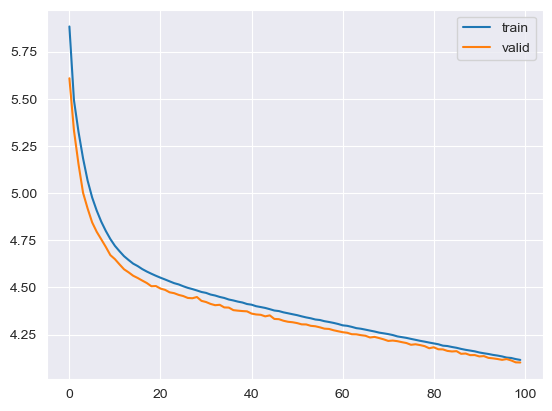

In [22]:
sns.lineplot(train_epoch_loss, label='train')
sns.lineplot(valid_epoch_loss, label='valid')